In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from sklearn.metrics import mean_squared_error

In [2]:
# Data Loading and Preprocessing
data = pd.read_csv("Covid_Data_Canada.csv")
data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y")
data = data[data['Date'].dt.year == 2020]

days = 188
date_range = data['Date'].iloc[:days]
N = 37742154
real_infected = data['Active'].values[:days]

In [3]:
# --------------- #
# SIR Model
# --------------- #

def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def run_sir_simulation(beta, gamma, S0, I0, R0, days):
    t = np.linspace(0, days, days)
    y0 = S0, I0, R0
    ret = odeint(sir_model, y0, t, args=(beta, gamma))
    S, I, R = ret.T
    return I

def monte_carlo_sir(runs, param_ranges, initial_conditions, days, with_interventions=False):
    results = []
    for _ in range(runs):
        beta = random.uniform(*param_ranges['beta'])
        gamma = random.uniform(*param_ranges['gamma'])
        I0, R0 = initial_conditions['I0'], initial_conditions['R0']

        if with_interventions:
            vaccination = random.uniform(0.05, 0.4)
            distancing = random.uniform(0.1, 0.5)
            masking = random.uniform(0.1, 0.3)
            gamma_boost = random.uniform(0.01, 0.05)

            beta *= (1 - distancing) * (1 - masking)
            gamma += gamma_boost
            S0 = (N - I0 - R0) * (1 - vaccination)
        else:
            S0 = N - I0 - R0

        I = run_sir_simulation(beta, gamma, S0, I0, R0, days)
        results.append(I[:days])
    return np.mean(results, axis=0)



In [4]:
# --------------- #
# SEIR Model
# --------------- #

def seir_model(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

def run_seir_simulation(beta, sigma, gamma, S0, E0, I0, R0, days):
    t = np.linspace(0, days, days)
    y0 = S0, E0, I0, R0
    ret = odeint(seir_model, y0, t, args=(beta, sigma, gamma))
    S, E, I, R = ret.T
    return I

def monte_carlo_seir(runs, param_ranges, initial_conditions, days, with_interventions=False):
    results = []
    for _ in range(runs):
        beta = random.uniform(*param_ranges['beta'])
        sigma = random.uniform(*param_ranges['sigma'])
        gamma = random.uniform(*param_ranges['gamma'])
        I0, E0, R0 = initial_conditions['I0'], initial_conditions['E0'], initial_conditions['R0']

        if with_interventions:
            vaccination = random.uniform(0.05, 0.4)
            distancing = random.uniform(0.1, 0.5)
            masking = random.uniform(0.1, 0.3)
            gamma_boost = random.uniform(0.01, 0.05)
            sigma_boost = random.uniform(0.01, 0.05)

            beta *= (1 - distancing) * (1 - masking)
            gamma += gamma_boost
            sigma += sigma_boost
            S0 = (N - I0 - E0 - R0) * (1 - vaccination)
        else:
            S0 = N - I0 - E0 - R0

        I = run_seir_simulation(beta, sigma, gamma, S0, E0, I0, R0, days)
        results.append(I[:days])
    return np.mean(results, axis=0)

In [5]:
### MAIN EXECUTION ###
runs = 100
sir_params = {'beta': (0.1, 0.5), 'gamma': (0.05, 0.2)}
seir_params = {'beta': (0.1, 0.5), 'sigma': (1/7, 1/3), 'gamma': (0.05, 0.2)}
sir_init = {'I0': 100, 'R0': 0}
seir_init = {'I0': 100, 'E0': 50, 'R0': 0}

# Run all simulations
sir_baseline = monte_carlo_sir(runs, sir_params, sir_init, days, with_interventions=False)
sir_intervention = monte_carlo_sir(runs, sir_params, sir_init, days, with_interventions=True)
seir_baseline = monte_carlo_seir(runs, seir_params, seir_init, days, with_interventions=False)
seir_intervention = monte_carlo_seir(runs, seir_params, seir_init, days, with_interventions=True)


In [6]:
### RMSE Evaluation ###

def compute_rmse(predicted, actual):
    return np.sqrt(mean_squared_error(actual, predicted))

rmse_sir_before = compute_rmse(sir_baseline, real_infected)
rmse_sir_after = compute_rmse(sir_intervention, real_infected)
rmse_seir_before = compute_rmse(seir_baseline, real_infected)
rmse_seir_after = compute_rmse(seir_intervention, real_infected)

print(f"RMSE - SIR (Before Interventions): {rmse_sir_before:.2f}")
print(f"RMSE - SIR (After Interventions):  {rmse_sir_after:.2f}")
print(f"RMSE - SEIR (Before Interventions): {rmse_seir_before:.2f}")
print(f"RMSE - SEIR (After Interventions):  {rmse_seir_after:.2f}")


RMSE - SIR (Before Interventions): 2081841.75
RMSE - SIR (After Interventions):  98987.38
RMSE - SEIR (Before Interventions): 1539949.53
RMSE - SEIR (After Interventions):  42541.86


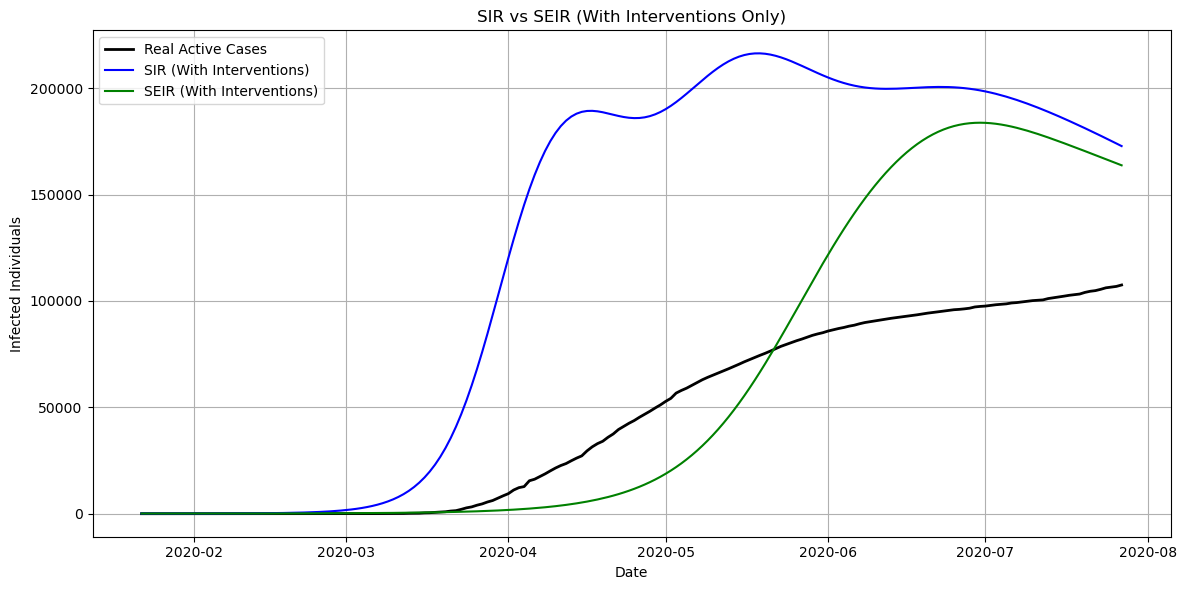

In [7]:
### Focused Plot : SIR VS SEIR (With interventions strategies) ###

plt.figure(figsize=(12, 6))

plt.plot(date_range, real_infected, label="Real Active Cases", color='black', linewidth=2)
plt.plot(date_range, sir_intervention, label="SIR (With Interventions)", color='blue')
plt.plot(date_range, seir_intervention, label="SEIR (With Interventions)", color='green')

plt.title("SIR vs SEIR (With Interventions Only)")
plt.xlabel("Date")
plt.ylabel("Infected Individuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

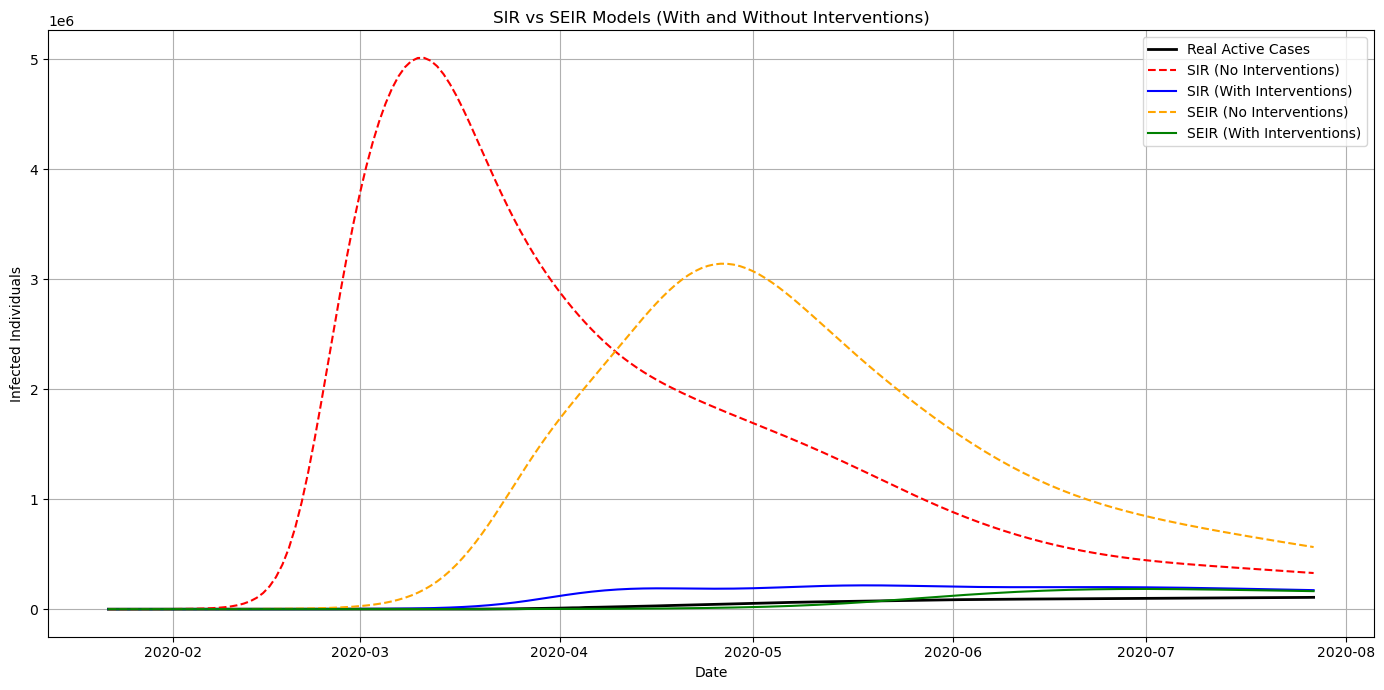

In [8]:
### Plotting All Models Together : Before Intervention VS After Intervention
plt.figure(figsize=(14, 7))
plt.plot(date_range, real_infected, label="Real Active Cases", color='black', linewidth=2)
plt.plot(date_range, sir_baseline, label="SIR (No Interventions)", color='red', linestyle='--')
plt.plot(date_range, sir_intervention, label="SIR (With Interventions)", color='blue')
plt.plot(date_range, seir_baseline, label="SEIR (No Interventions)", color='orange', linestyle='--')
plt.plot(date_range, seir_intervention, label="SEIR (With Interventions)", color='green')

plt.title("SIR vs SEIR Models (With and Without Interventions)")
plt.xlabel("Date")
plt.ylabel("Infected Individuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



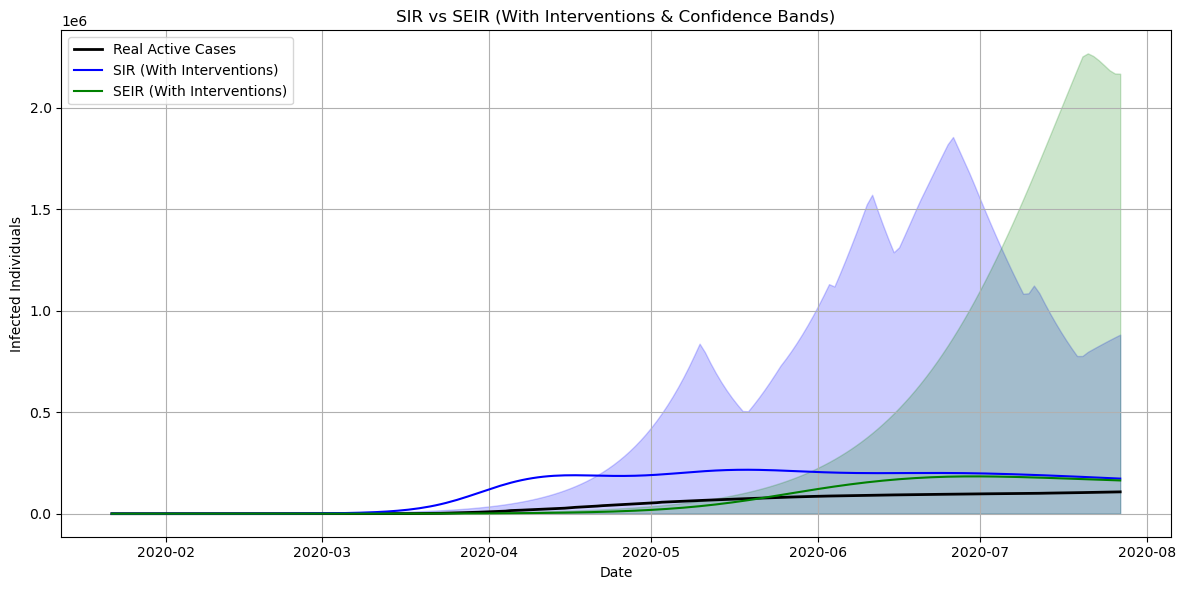

In [9]:
# ----------------------- #
# Confidence Bands: SIR and SEIR with Interventions
# ----------------------- #
sir_runs_all = [run_sir_simulation(
    beta=random.uniform(*sir_params['beta']) * (1 - random.uniform(0.1, 0.5)) * (1 - random.uniform(0.1, 0.3)),
    gamma=random.uniform(*sir_params['gamma']) + random.uniform(0.01, 0.05),
    S0=(N - sir_init['I0'] - sir_init['R0']) * (1 - random.uniform(0.05, 0.4)),
    I0=sir_init['I0'],
    R0=sir_init['R0'],
    days=days
) for _ in range(runs)]

seir_runs_all = [run_seir_simulation(
    beta=random.uniform(*seir_params['beta']) * (1 - random.uniform(0.1, 0.5)) * (1 - random.uniform(0.1, 0.3)),
    sigma=random.uniform(*seir_params['sigma']) + random.uniform(0.01, 0.05),
    gamma=random.uniform(*seir_params['gamma']) + random.uniform(0.01, 0.05),
    S0=(N - seir_init['I0'] - seir_init['E0'] - seir_init['R0']) * (1 - random.uniform(0.05, 0.4)),
    E0=seir_init['E0'],
    I0=seir_init['I0'],
    R0=seir_init['R0'],
    days=days
) for _ in range(runs)]

sir_I_all = np.array(sir_runs_all)
seir_I_all = np.array(seir_runs_all)

# Compute percentiles for bands
sir_lower = np.percentile(sir_I_all, 5, axis=0)
sir_upper = np.percentile(sir_I_all, 95, axis=0)
seir_lower = np.percentile(seir_I_all, 5, axis=0)
seir_upper = np.percentile(seir_I_all, 95, axis=0)

# ----------------------------------------------------------------------------- #
# Plot: SIR and SEIR with Interventions + Confidence Bands
# ----------------------------------------------------------------------------- #
plt.figure(figsize=(12, 6))

plt.plot(date_range, real_infected[:days], label="Real Active Cases", color='black', linewidth=2)

# SIR
plt.plot(date_range, sir_intervention, label="SIR (With Interventions)", color='blue')
plt.fill_between(date_range, sir_lower, sir_upper, color='blue', alpha=0.2)

# SEIR
plt.plot(date_range, seir_intervention, label="SEIR (With Interventions)", color='green')
plt.fill_between(date_range, seir_lower, seir_upper, color='green', alpha=0.2)

plt.title("SIR vs SEIR (With Interventions & Confidence Bands)")
plt.xlabel("Date")
plt.ylabel("Infected Individuals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()